# Imports

In [1]:
import psycopg2
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [2]:
def conn_curs():
    dbname = "kplbotdt"
    password = "Ydvw5clyK3HO0otQBITuyJY_nyThD7-L"
    host = "lallah.db.elephantsql.com"

    connection = psycopg2.connect(dbname=dbname, user=dbname,
                                  password=password, host=host)
    cursor = connection.cursor()
    return connection, cursor

# Query the data

In [3]:
conn, curs = conn_curs()
df = pd.read_sql("SELECT * FROM posts", conn)

In [4]:
df.head()

,id,title_selftext,subreddit,subreddit_id,num_comments,upvotes,downvotes,flair,has_vid,num_awards
0,1,Happy 33rd birthday to gorgeous Blake Lively! ✨,GossipGirl,t5_2rn7c,27,572,0,None,False,0
1,2,You and I both know... I’ve seen plenty of peo...,GossipGirl,t5_2rn7c,7,24,0,None,False,0
2,3,"Will or Keith Van der Woodsen, the difference?...",GossipGirl,t5_2rn7c,2,5,0,None,False,0
3,4,Carter & Blair should have been a thing (possi...,GossipGirl,t5_2rn7c,9,10,0,None,False,0
4,5,Colin & Serena (possible spoilers) Colin and S...,GossipGirl,t5_2rn7c,2,4,0,None,False,0


In [5]:
df.drop('id', axis=1, inplace=True)

# Drop Duplicates

In [6]:
df.drop_duplicates(subset=['subreddit', 'title_selftext'], inplace=True)

In [7]:
counts = df.subreddit.value_counts()
counts

AskOuija              63
unrealengine          48
whatsthisbug          44
ApplyingToCollege     41
MouseReview           39
                      ..
Amouranth             17
randonauts             6
woof_irl               6
dankmemes              2
DomesticGirlfriend     1
Name: subreddit, Length: 889, dtype: int64

/home/allan/.local/share/virtualenvs/DS-g1hPcujF/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


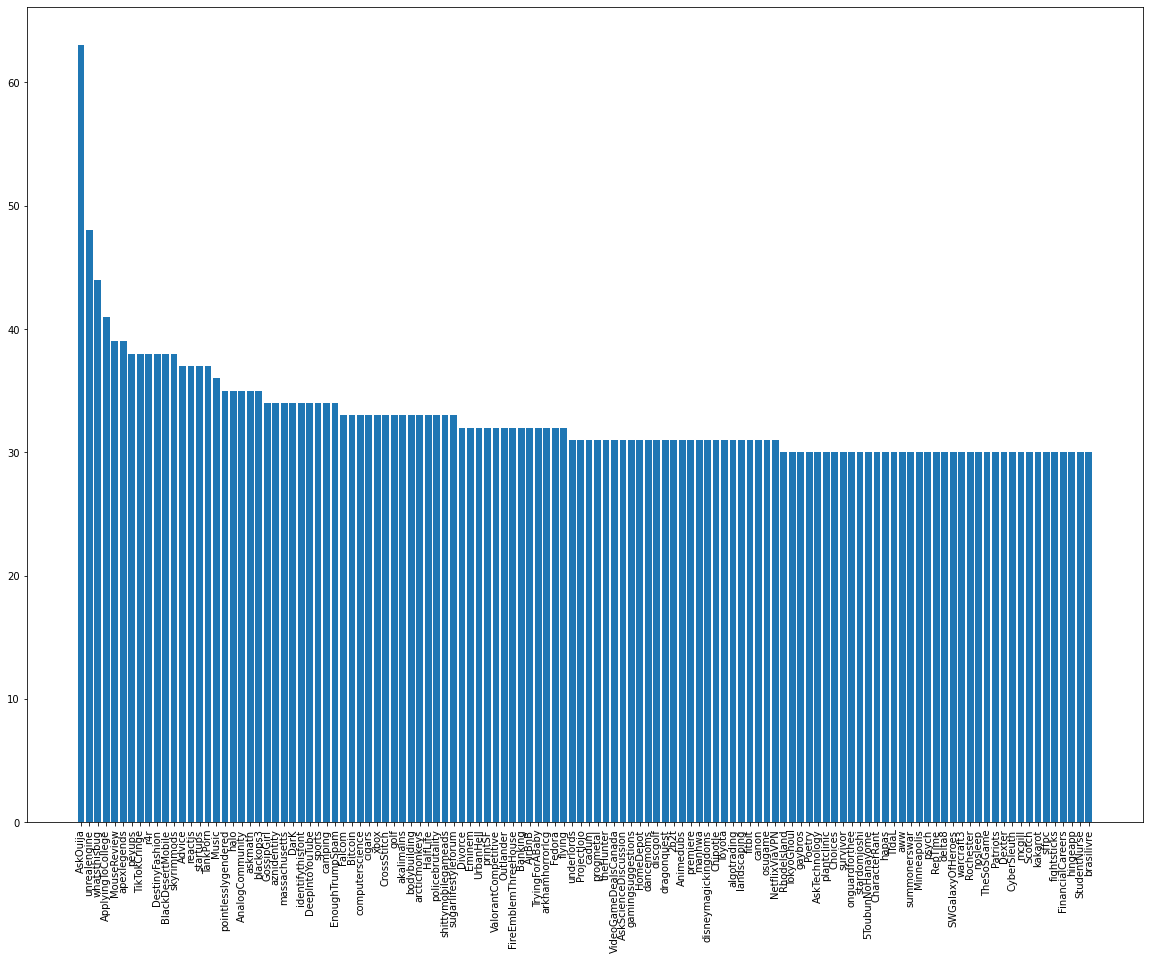

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)

ax.bar(x=range(1, 121), height=counts[:120])
ax.set_xticks(range(1, 121))
ax.set_xticklabels(counts.keys()[:120], rotation='vertical')

fig.show()

# More cleaning

In [9]:
df.head(1)

,title_selftext,subreddit,subreddit_id,num_comments,upvotes,downvotes,flair,has_vid,num_awards
0,Happy 33rd birthday to gorgeous Blake Lively! ✨,GossipGirl,t5_2rn7c,27,572,0,None,False,0


In [10]:
df.drop(['subreddit_id','num_comments','downvotes','num_awards','flair'], axis=1, inplace=True)  # flair has high card

In [11]:
df.head(1)

,title_selftext,subreddit,upvotes,has_vid
0,Happy 33rd birthday to gorgeous Blake Lively! ✨,GossipGirl,572,False


# TTS

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('upvotes', axis=1), df.upvotes, test_size=0.33, random_state=42)

# Modeling

In [98]:
pipe = make_pipeline(ColumnTransformer([
    ("ord", OrdinalEncoder(), ['subreddit']),
    ("vect", TfidfVectorizer(min_df=.2, max_df=.47), 'title_selftext')],
    remainder='passthrough'), LinearRegression(n_jobs=-1))

In [99]:
pipe.fit(X_train, y_train);

In [100]:
print(f"Train score: {pipe.score(X_train, y_train)}")
print(f"Val score: {pipe.score(X_test, y_test)}")

Train score: 0.010606535516052729
Val score: 0.010191486538428163


In [101]:
print(f"Baseline MAE: {mean_absolute_error(y_train, [y_train.mean()] * len(y_train))}")
print(f"Baseline RMSE: {np.sqrt(mean_squared_error(y_train, [y_train.mean()] * len(y_train)))}")

Baseline MAE: 753.7642048900626
Baseline RMSE: 3321.1493492038603


In [102]:
print(f'Train MAE: {mean_absolute_error(y_train, pipe.predict(X_train))}')
print(f'Val MAE: {mean_absolute_error(y_test, pipe.predict(X_test))}')
print()
print(f'Train RMSE: {np.sqrt(mean_squared_error(y_train, pipe.predict(X_train)))}')
print(f'Val RMSE: {np.sqrt(mean_squared_error(y_test, pipe.predict(X_test)))}')

Train MAE: 750.1389190258441
Val MAE: 723.5469480174382

Train RMSE: 3303.48945252781
Val RMSE: 3104.9236955201886


In [ ]:
# 723, 3105

In [103]:
from sklearn.ensemble import RandomForestRegressor

In [108]:
forest = make_pipeline(ColumnTransformer([
    ("ord", OrdinalEncoder(), ['subreddit']),
    ("vect", TfidfVectorizer(min_df=.2, max_df=.47), 'title_selftext')],
    remainder='passthrough'), RandomForestRegressor(n_jobs=-1, random_state=42))

forest.fit(X_train, y_train);

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('ord',
                                                  OrdinalEncoder(categories='auto',
                                                                 dtype=<class 'numpy.float64'>),
                                                  ['subreddit']),
                                                 ('vect',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'...
                 RandomForestRegresso

In [109]:
print(f"Train score: {forest.score(X_train, y_train)}")
print(f"Val score: {forest.score(X_test, y_test)}")
print()
print(f'Train MAE: {mean_absolute_error(y_train, forest.predict(X_train))}')
print(f'Val MAE: {mean_absolute_error(y_test, forest.predict(X_test))}')
print()
print(f'Train RMSE: {np.sqrt(mean_squared_error(y_train, forest.predict(X_train)))}')
print(f'Val RMSE: {np.sqrt(mean_squared_error(y_test, forest.predict(X_test)))}')

Train score: 0.6625221160679644
Val score: -0.016867527462192555

Train MAE: 383.2170065132005
Val MAE: 679.1719561888052

Train RMSE: 1929.3502005714492
Val RMSE: 3147.0781572181672


In [ ]:
# 679, 3147

In [110]:
from sklearn.model_selection import GridSearchCV

In [115]:
param = {
    "randomforestregressor__n_estimators": [100,200,400,600],
    "randomforestregressor__criterion": ['mae', 'mse'],
    "randomforestregressor__max_depth": [None, 10, 30, 50, 100, 200, 400],
    "randomforestregressor__min_samples_split": [1, 2, 4, 7, 10, 20],
    "randomforestregressor__max_leaf_nodes": [1, 2, 5, 10, 30, 50],
    "randomforestregressor__max_features": ["auto", "sqrt", "log2"]
}
grid = GridSearchCV(estimator=forest, n_jobs=-1, cv=5, scoring="neg_mean_absolute_error", verbose=1, param_grid=param)

In [116]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 6048 candidates, totalling 30240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.8s


ValueError: Found unknown categories ['DomesticGirlfriend'] in column 0 during transform

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'randomforestregressor', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__ord', 'columntransformer__vect', 'columntransformer__ord__categories', 'columntransformer__ord__dtype', 'columntransformer__vect__analyzer', 'columntransformer__vect__binary', 'columntransformer__vect__decode_error', 'columntransformer__vect__dtype', 'columntransformer__vect__encoding', 'columntransformer__vect__input', 'columntransformer__vect__lowercase', 'columntransformer__vect__max_df', 'columntransformer__vect__max_features', 'columntransformer__vect__min_df', 'columntransformer__vect__ngram_range', 'columntransformer__vect__norm', 'columntransformer__vect__preprocessor', 'columntransformer__vect__smooth_idf', 'columntransformer__vect__stop_words', 'columntransformer__vec